In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/quality_elo_updated.csv')

In [3]:
df['new_match'] = df['elapsed_time'] == '00:00:00'

df['match_id'] = df['new_match'].cumsum()

df['win_rate'] = 1 / (1 + 10 ** ((df['elo2'] - df['elo1']) / 400))

## 卡方检验

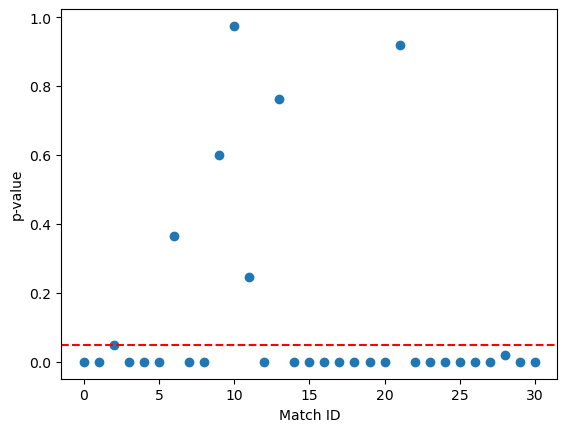

In [4]:
from scipy.stats import chisquare

p_values = []

for match_id in df['match_id'].unique():
    match_data = df[df['match_id'] == match_id]
    if not match_data.empty:

        observed = [sum(match_data['point_victor'] == 1), sum(match_data['point_victor'] == 2)]
        expected_rate = match_data.iloc[0]['win_rate']
        total_points = len(match_data)
        expected = [total_points * expected_rate, total_points * (1 - expected_rate)]
        
        chi2, p = chisquare(observed, f_exp=expected)
        p_values.append(p)

plt.scatter(range(len(p_values)), p_values)
plt.axhline(y=0.05, color='r', linestyle='--')
plt.xlabel('Match ID')
plt.ylabel('p-value')
plt.savefig('image/chi2.png', dpi=300) 
plt.show()

## ACF检验

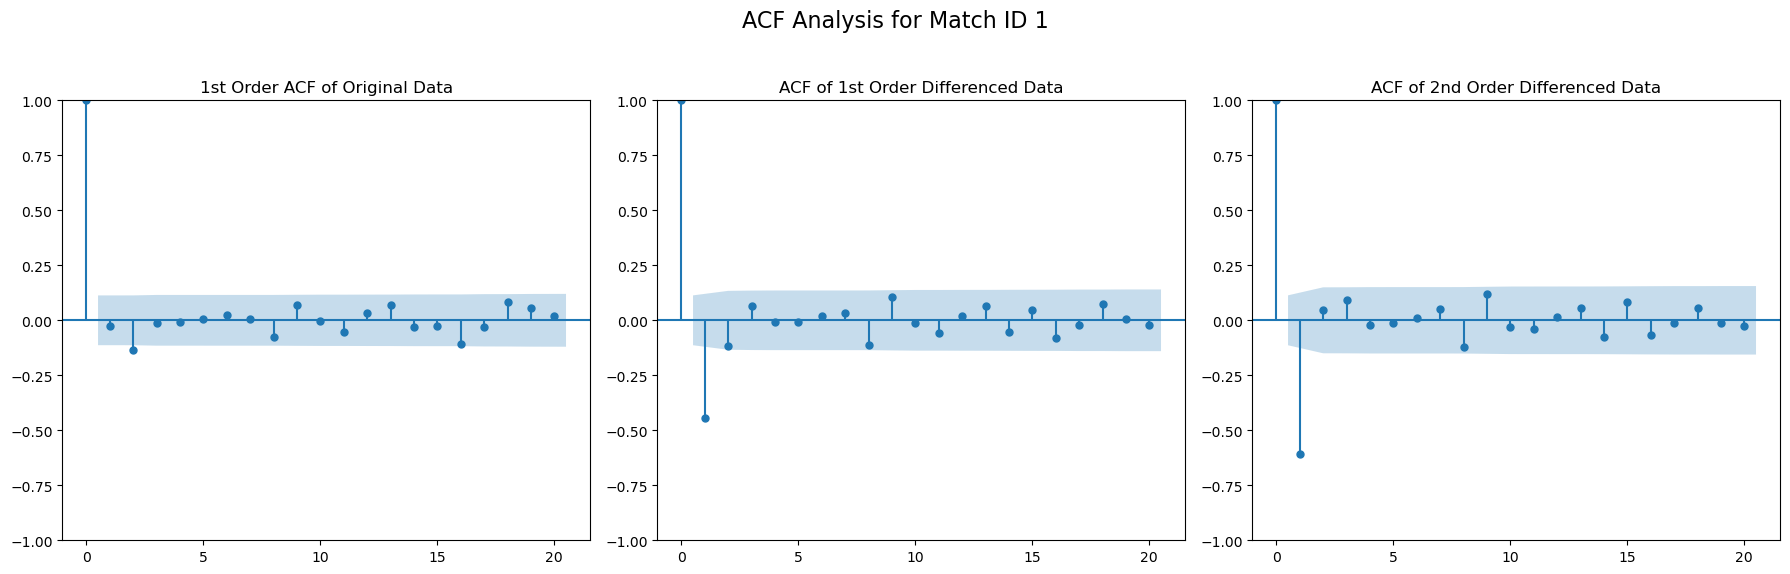

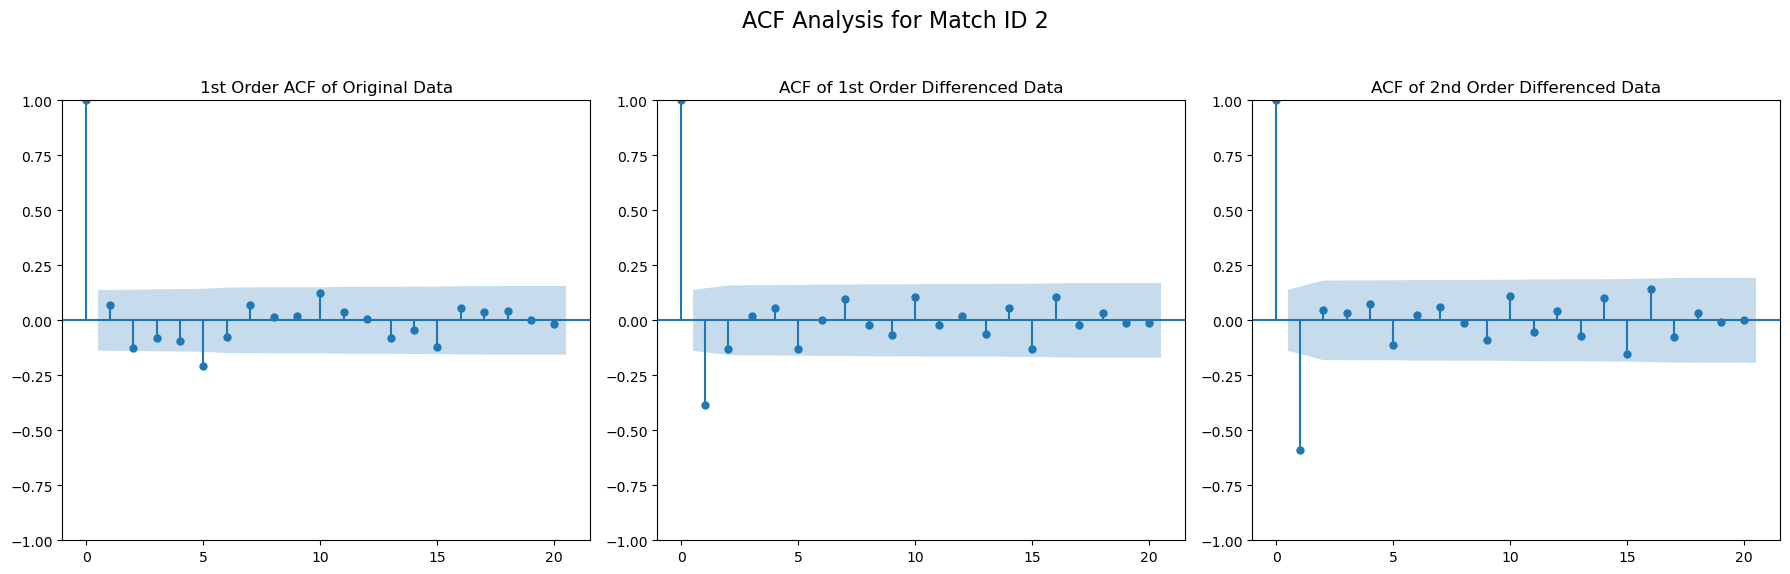

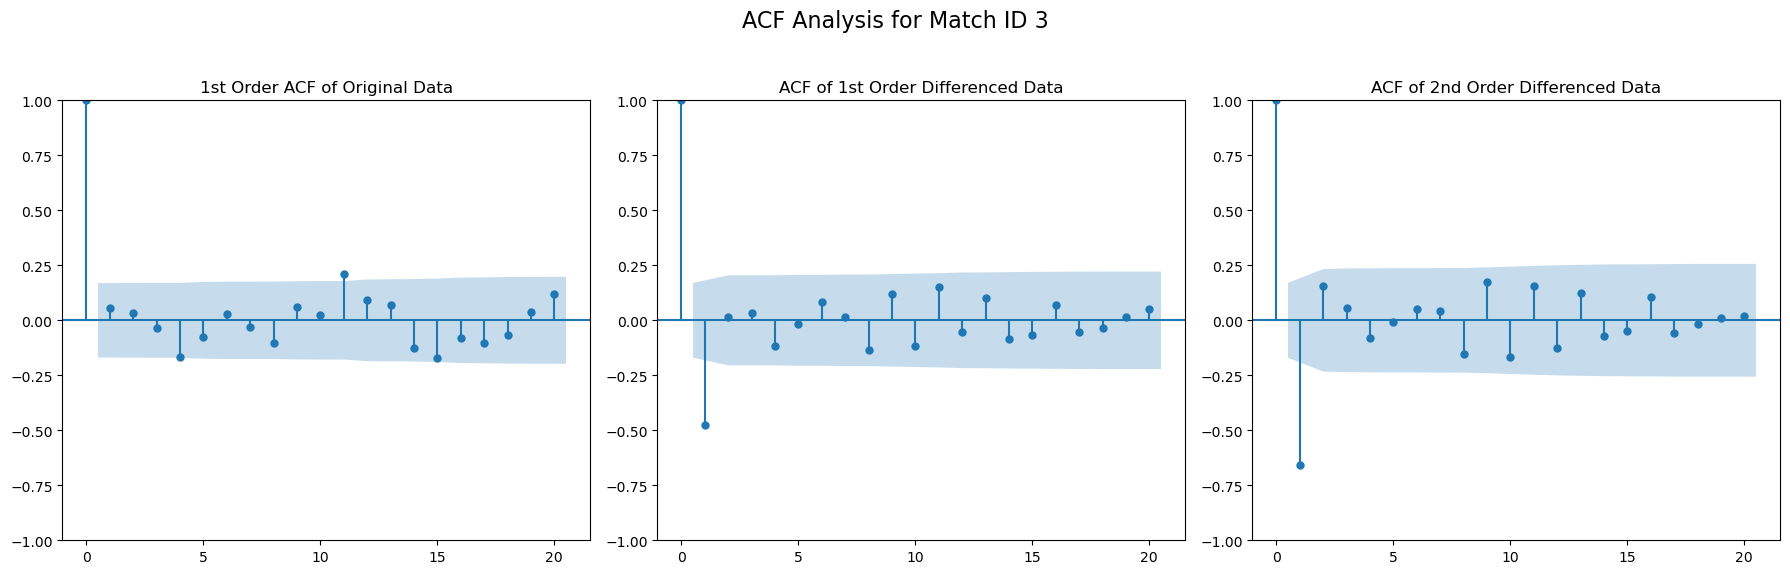

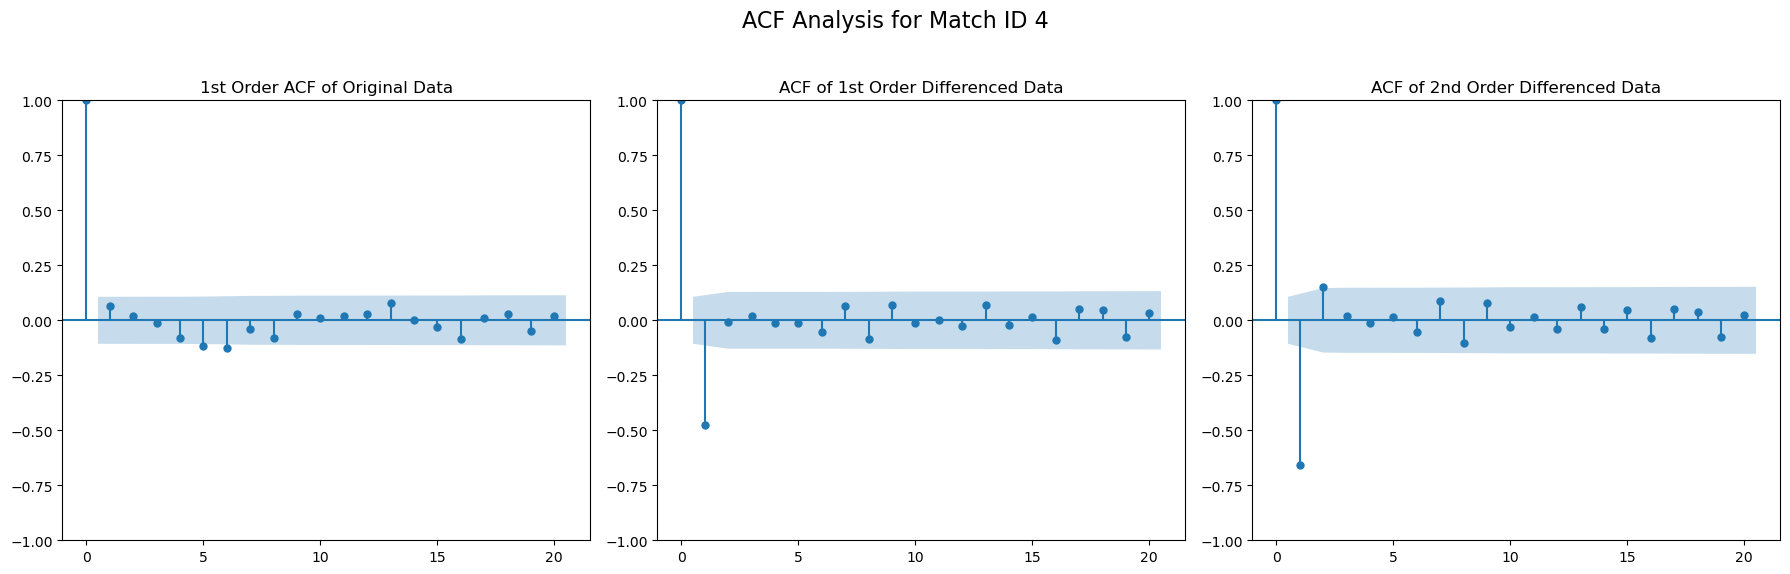

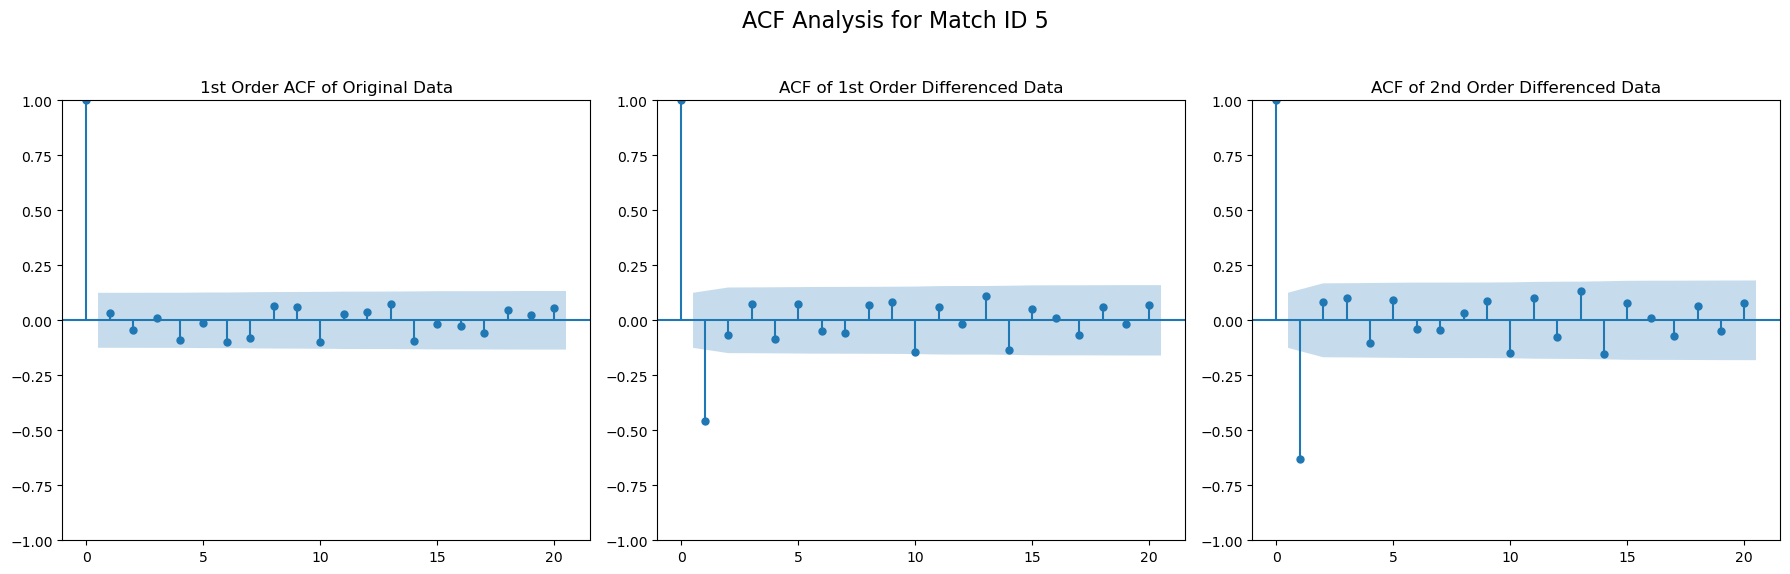

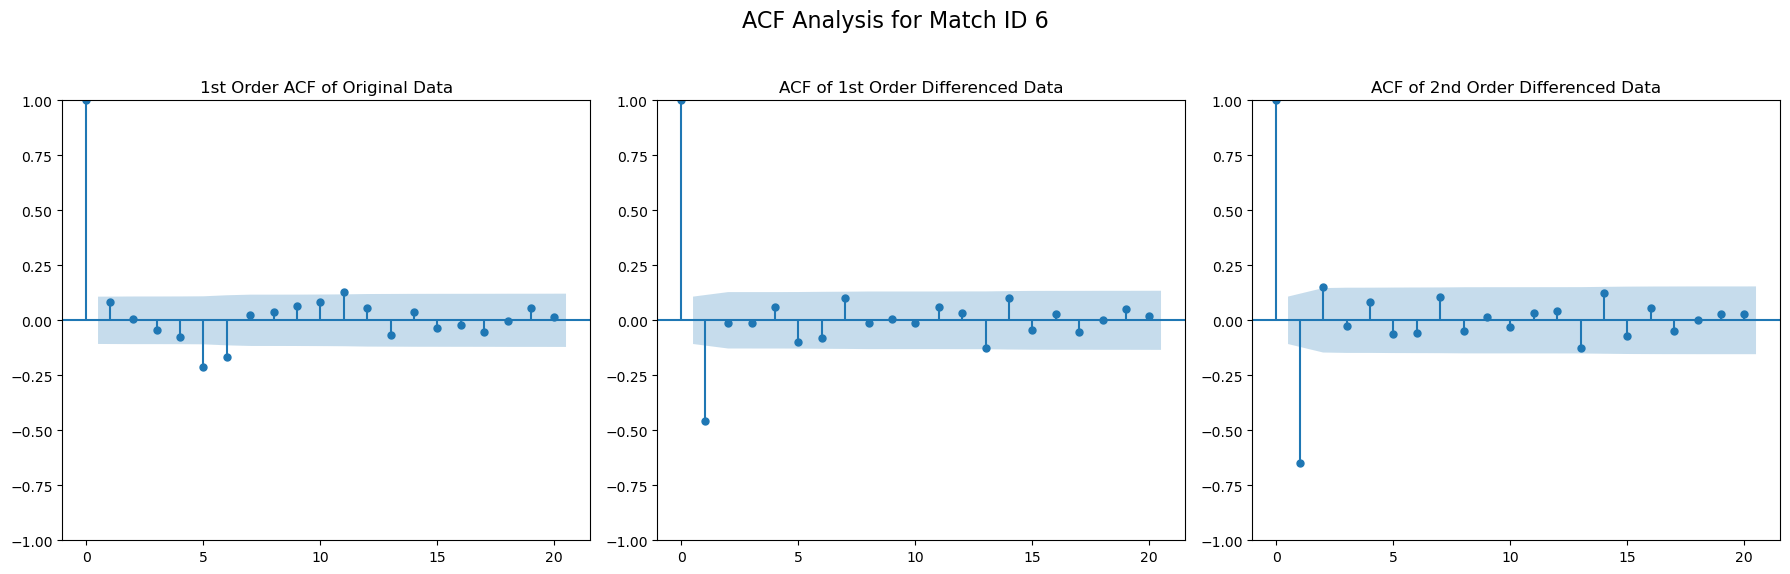

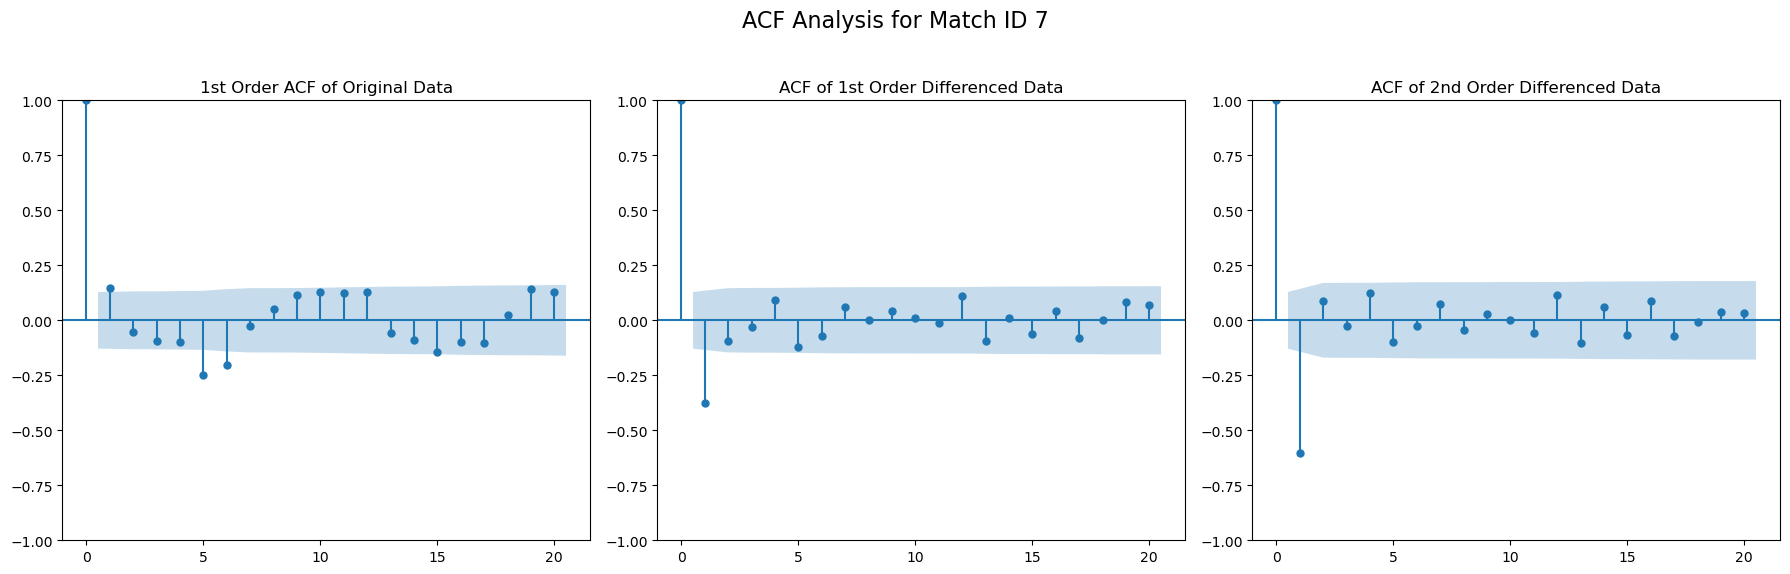

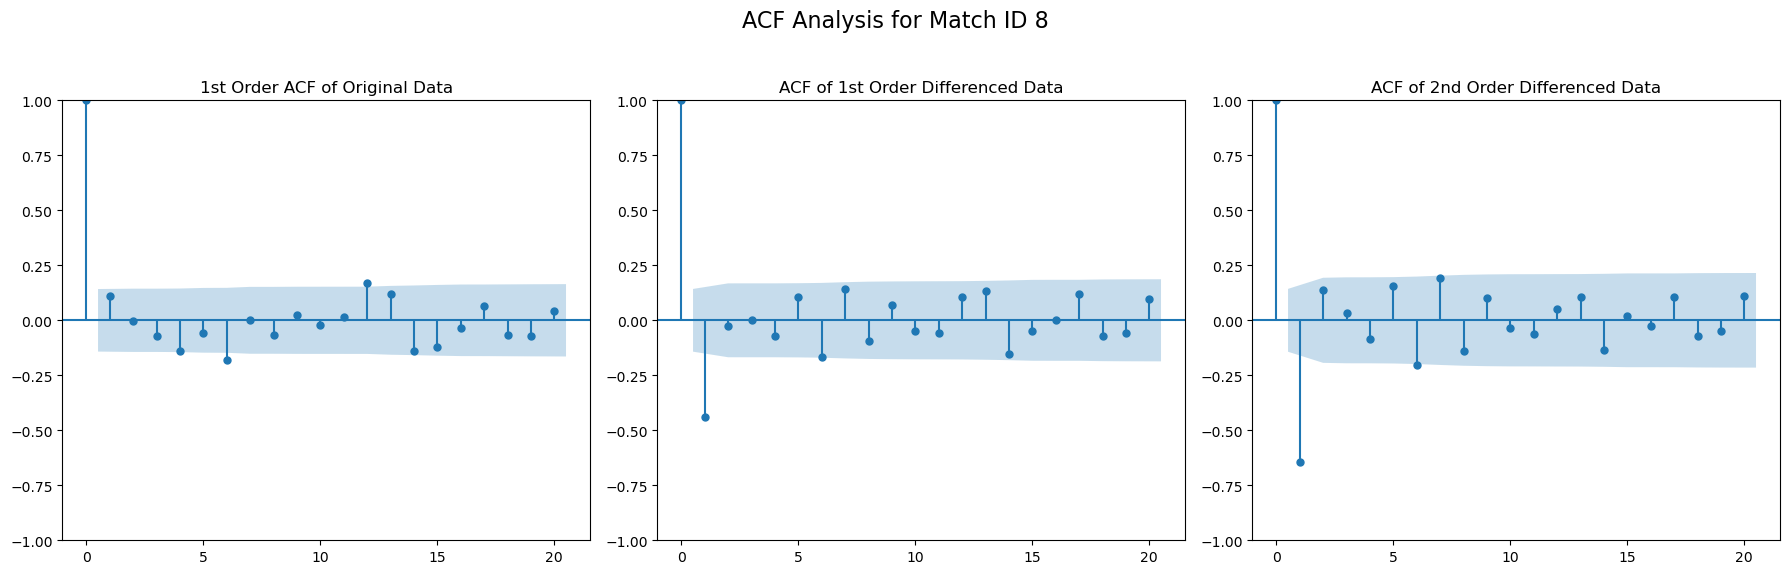

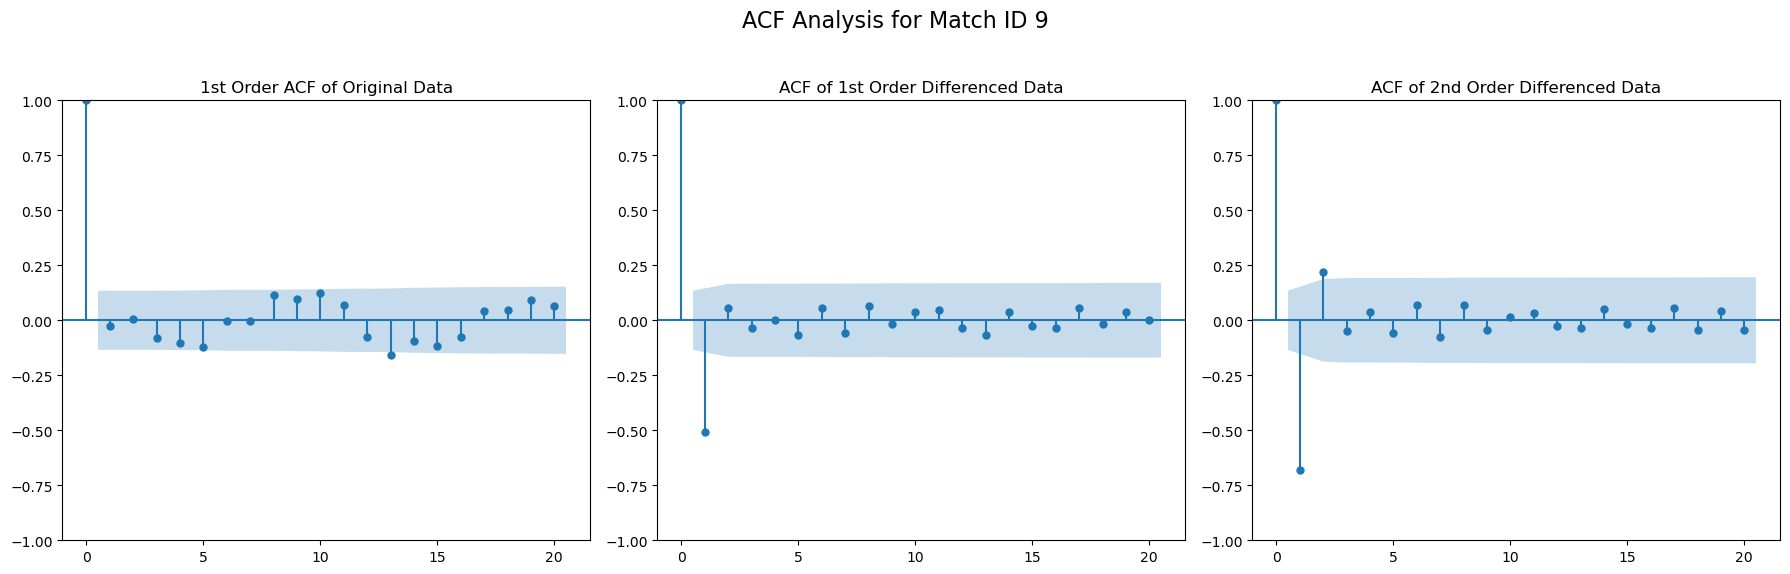

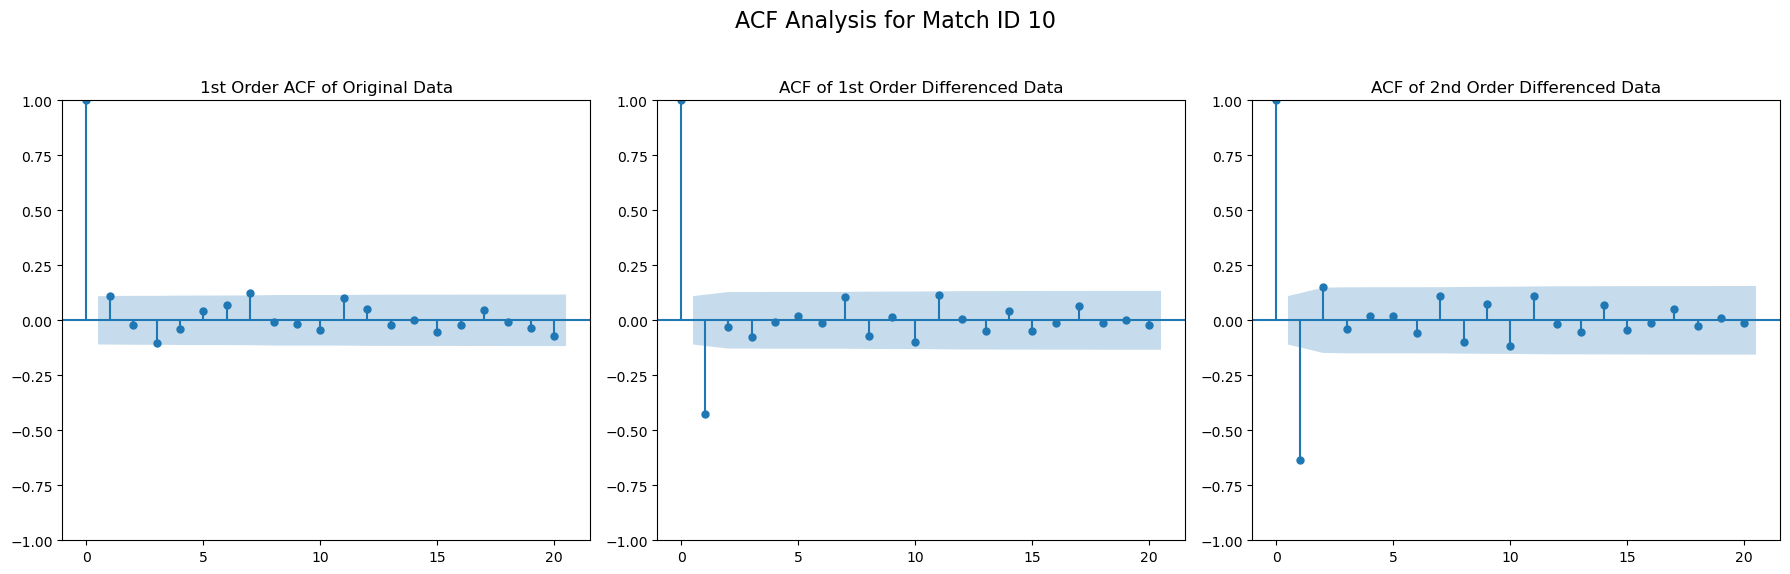

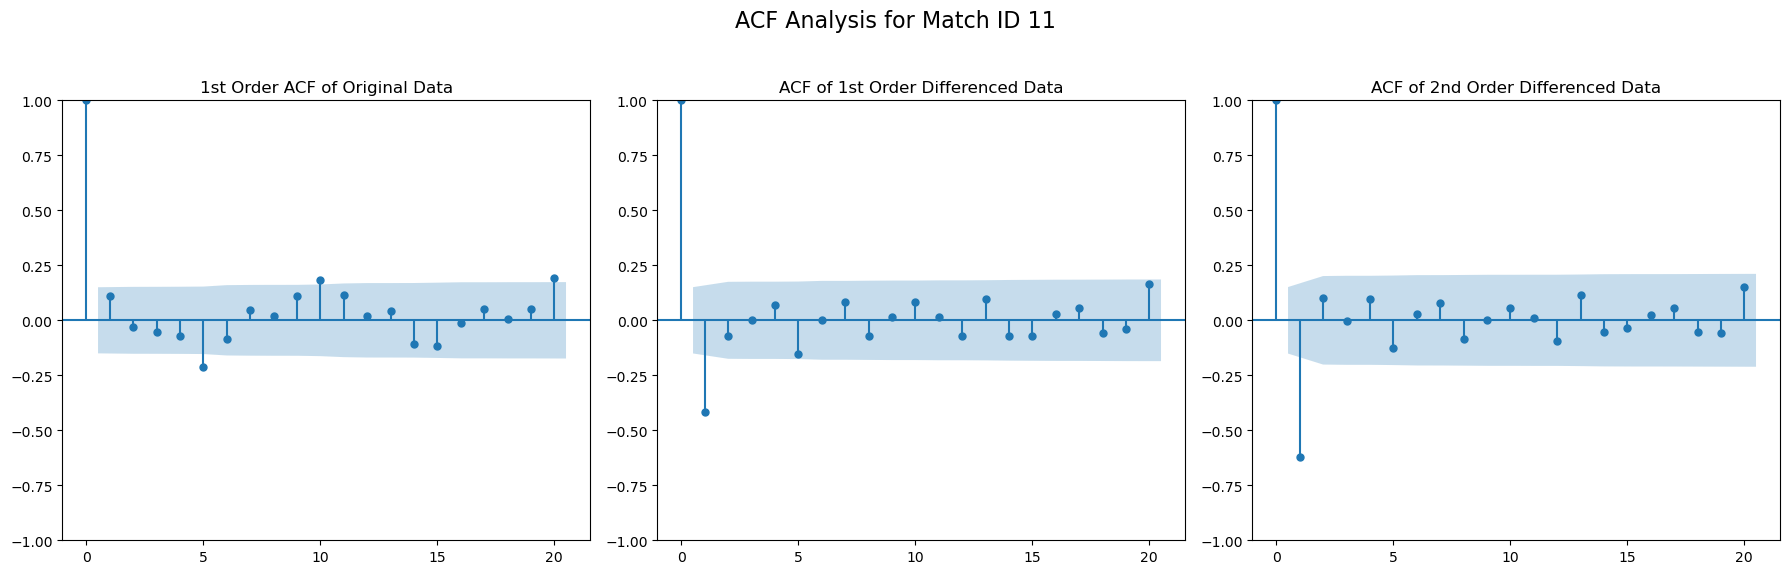

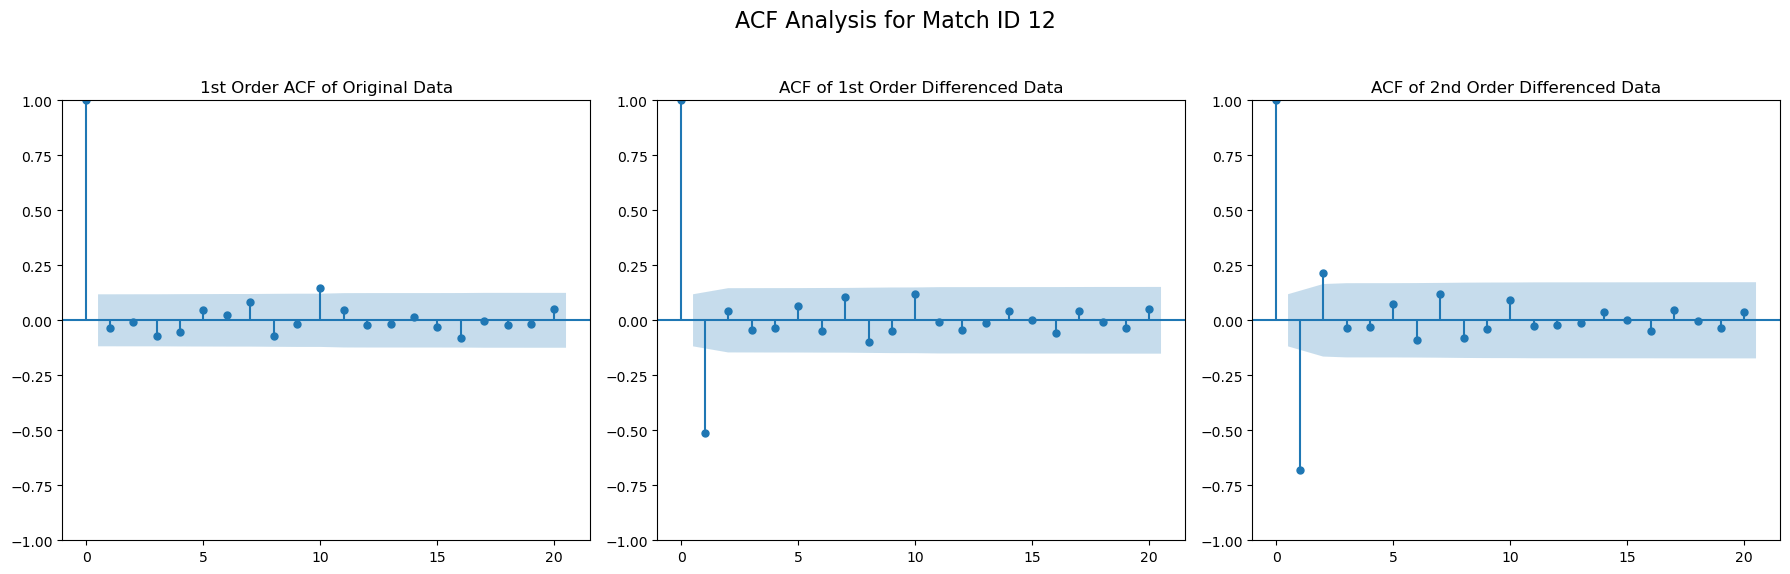

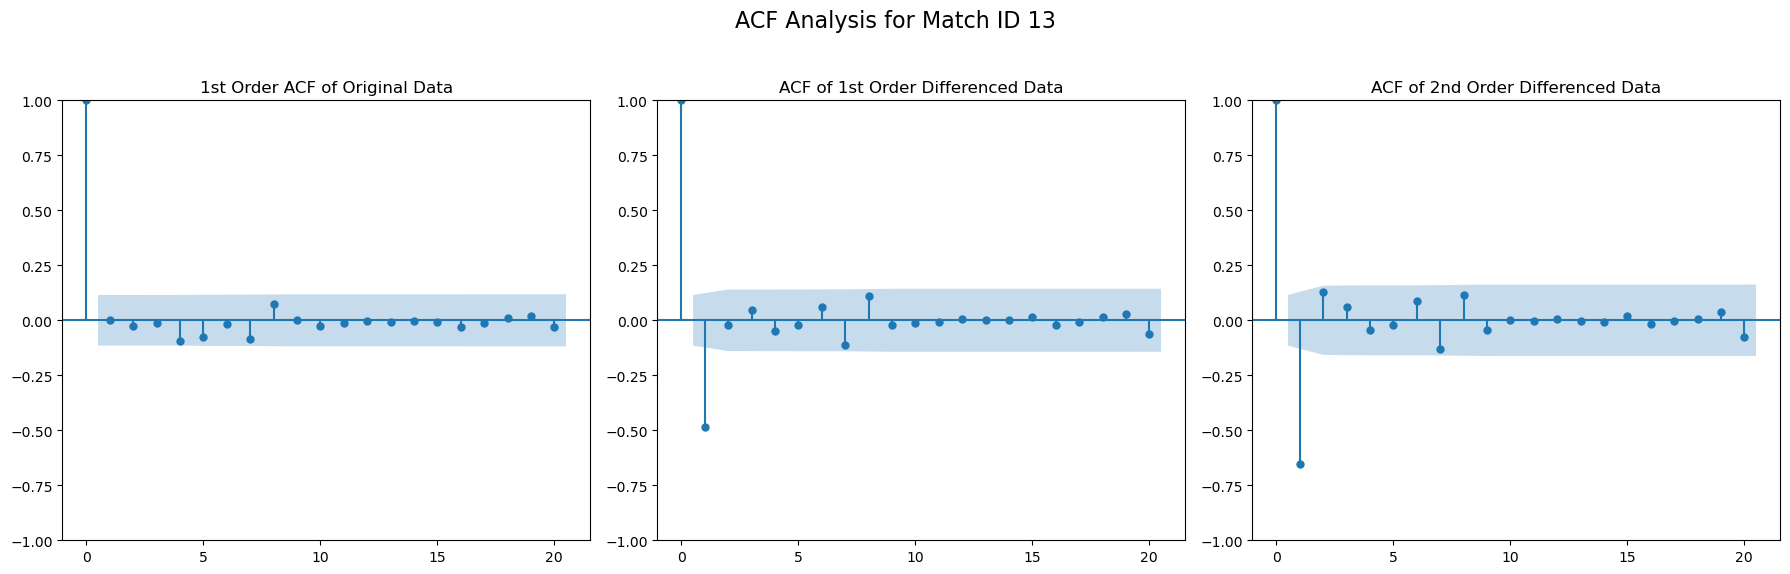

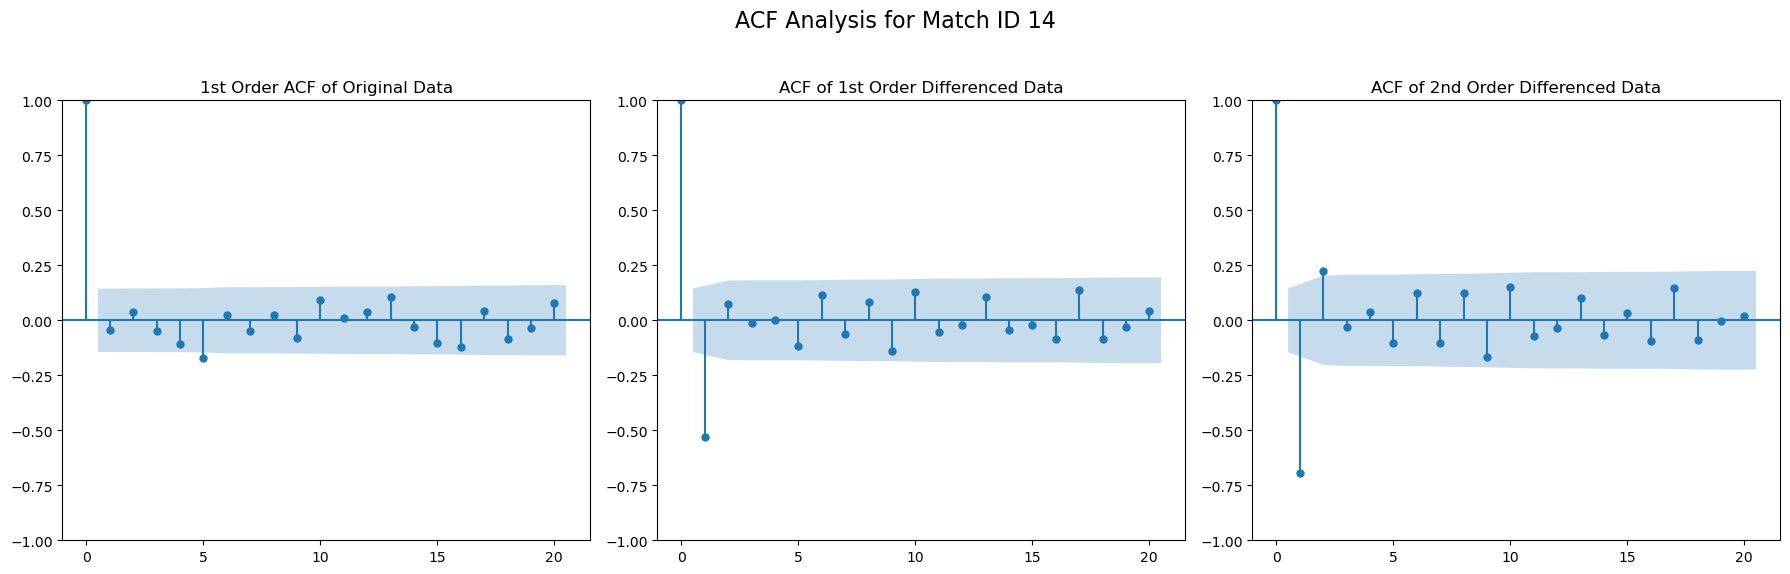

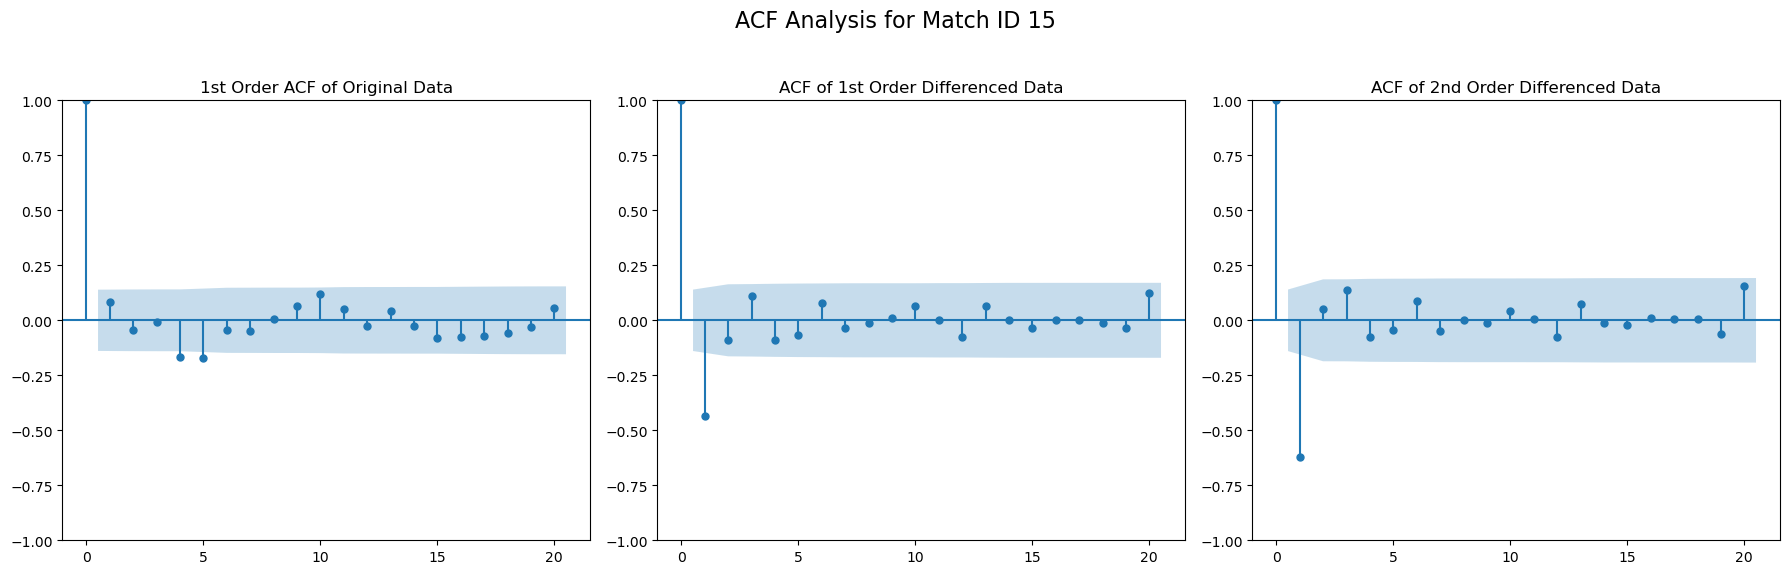

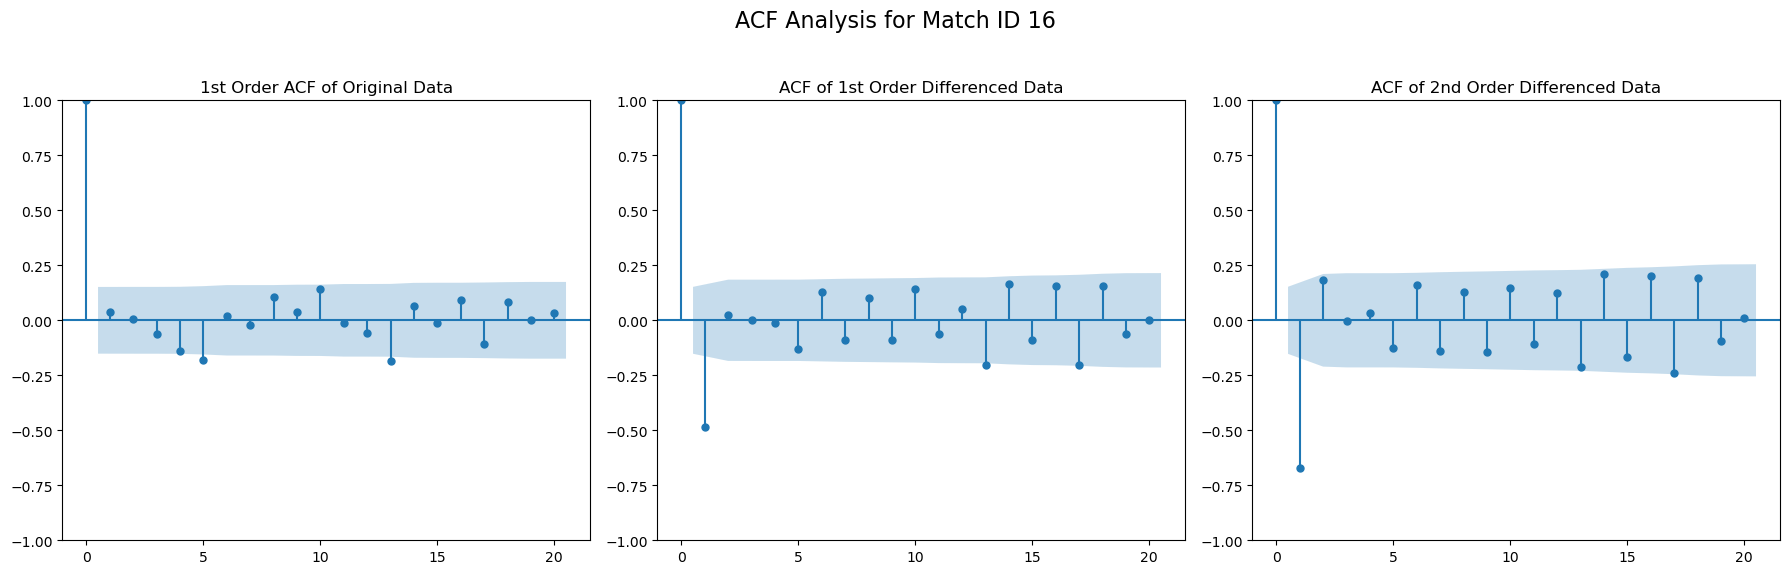

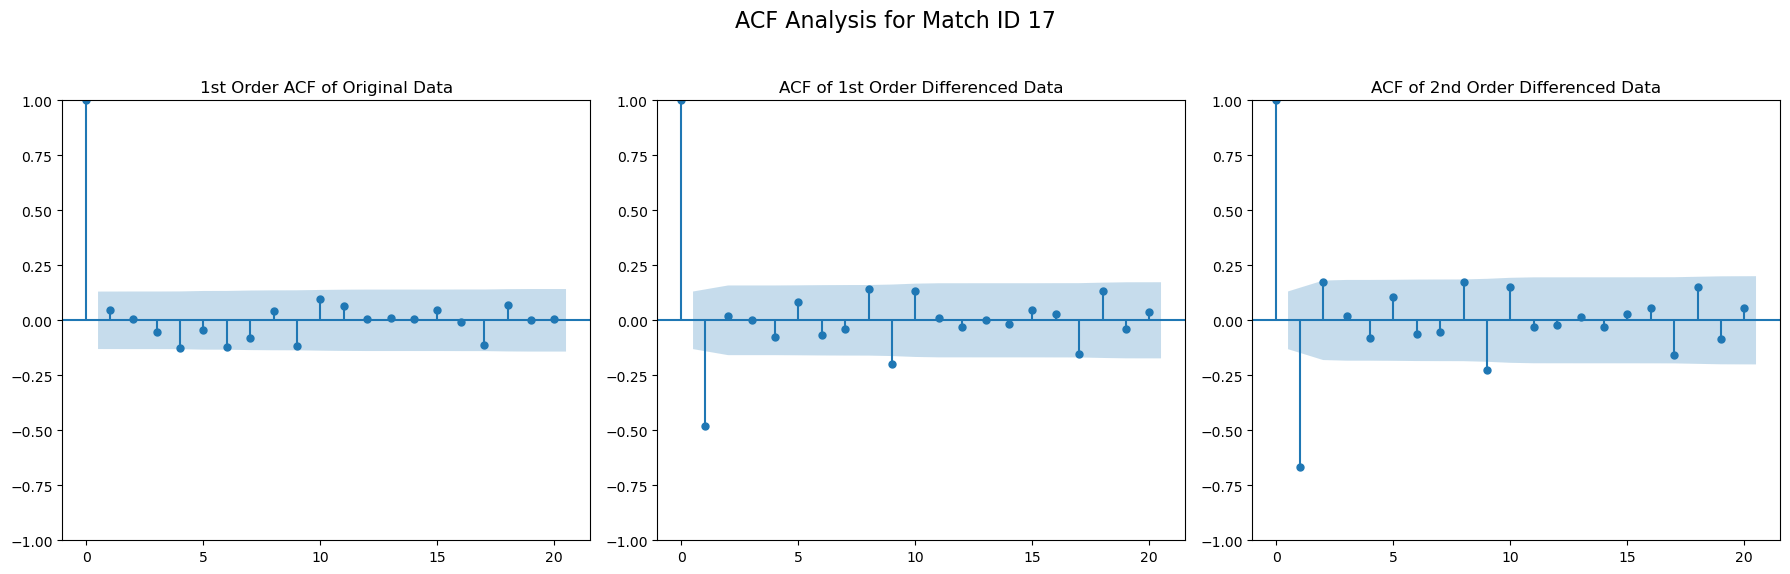

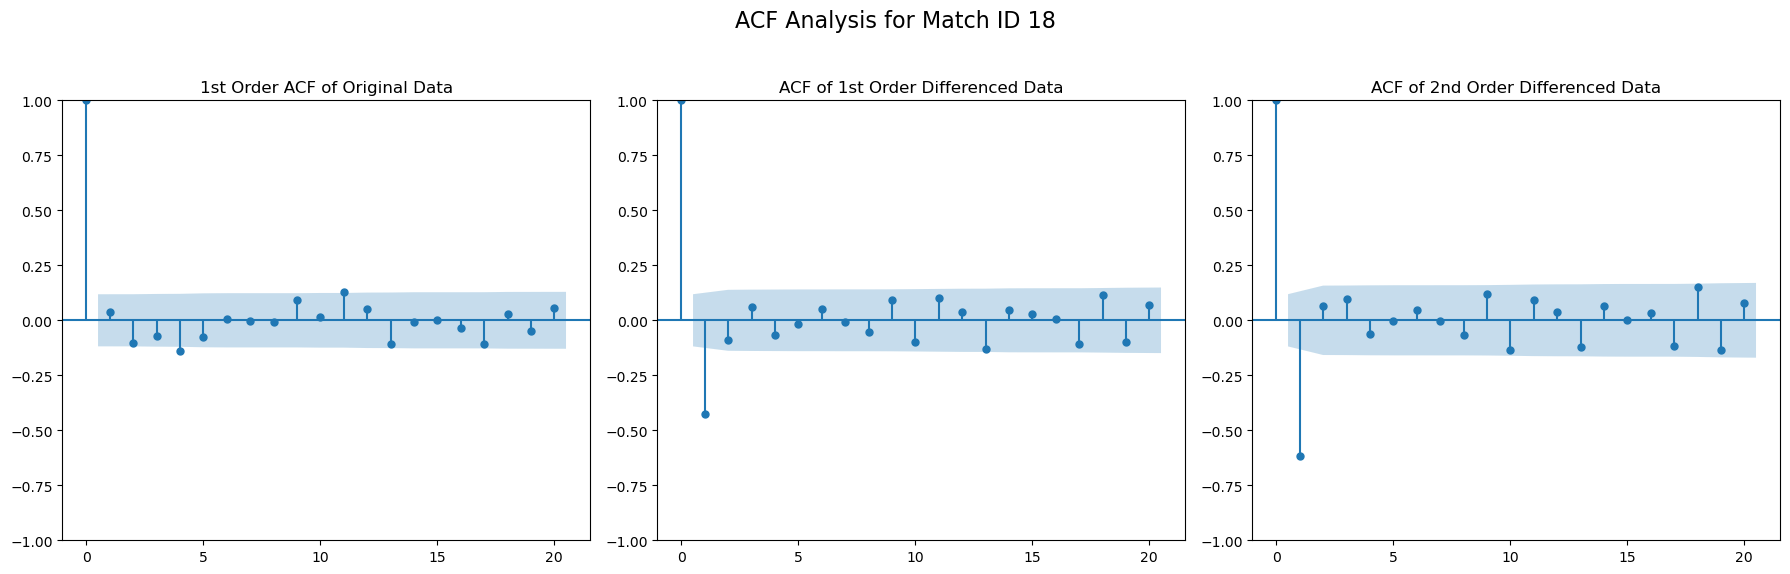

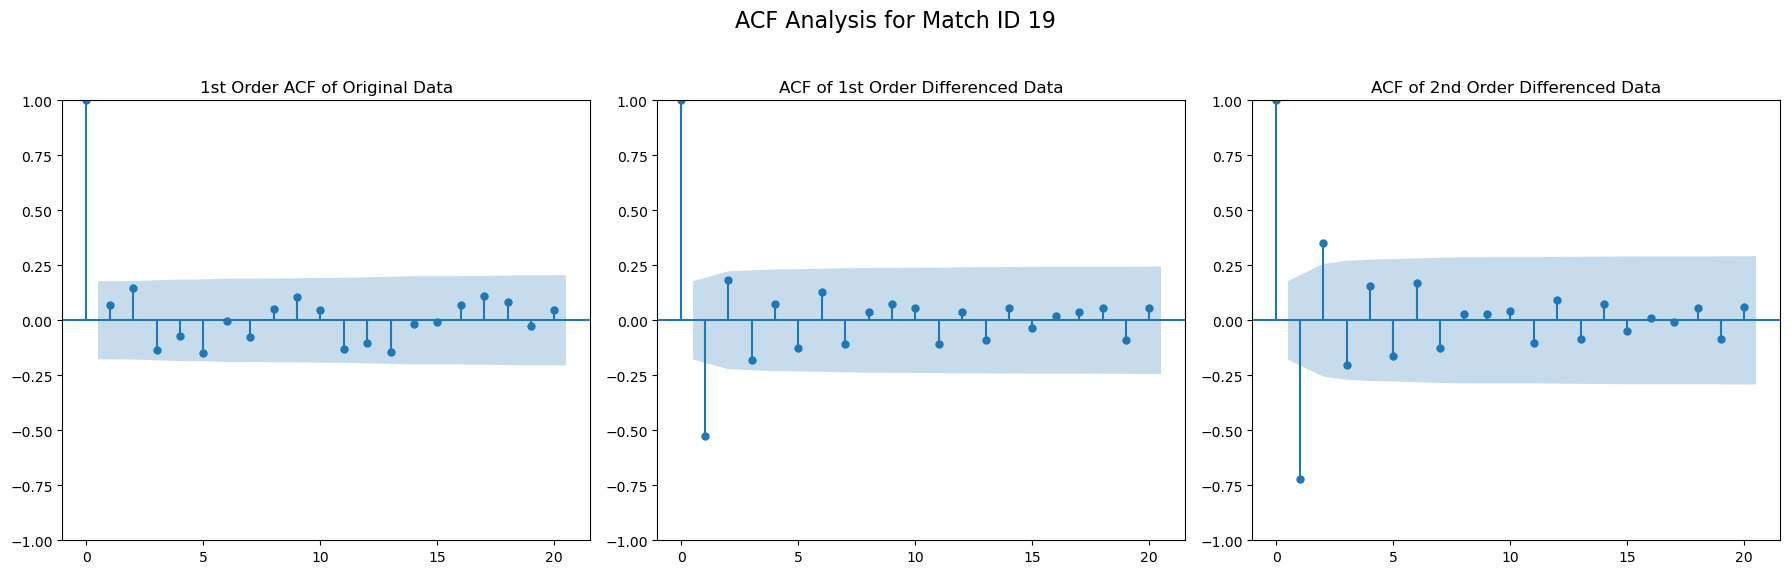

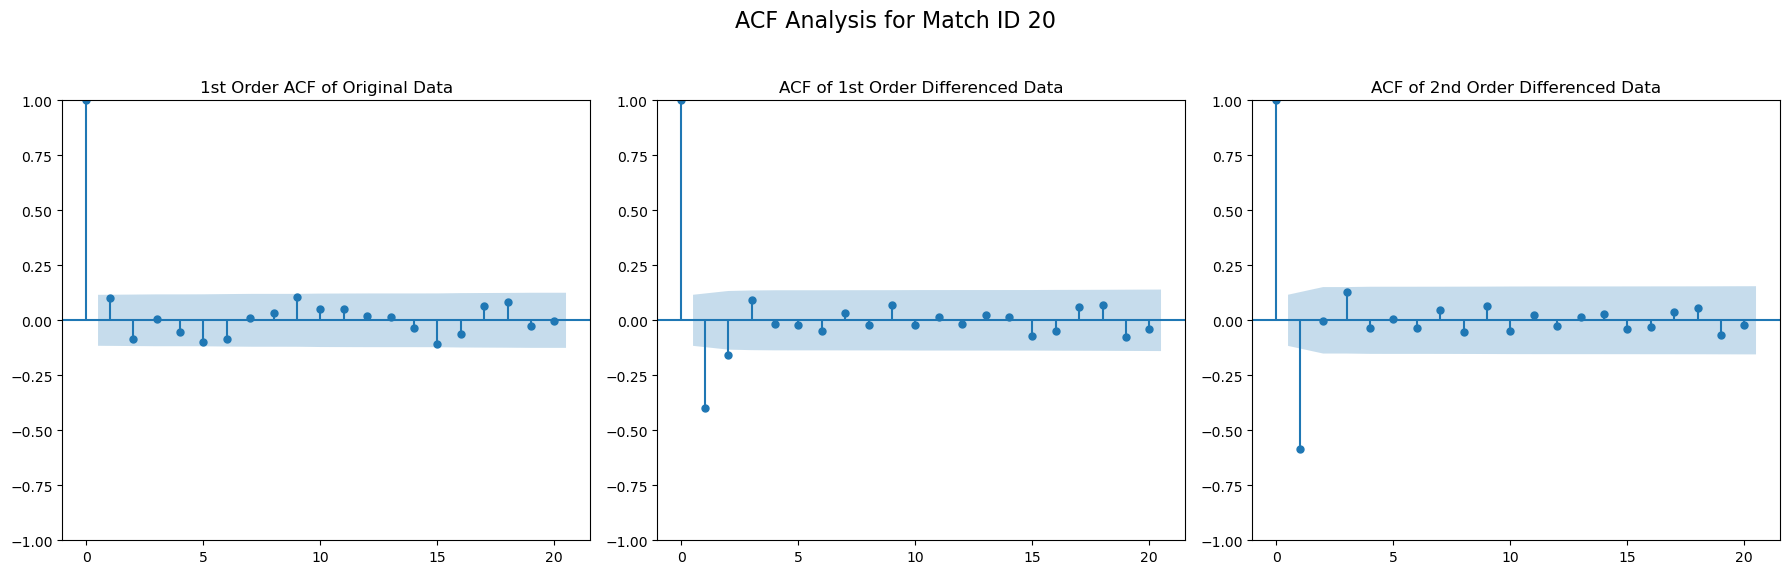

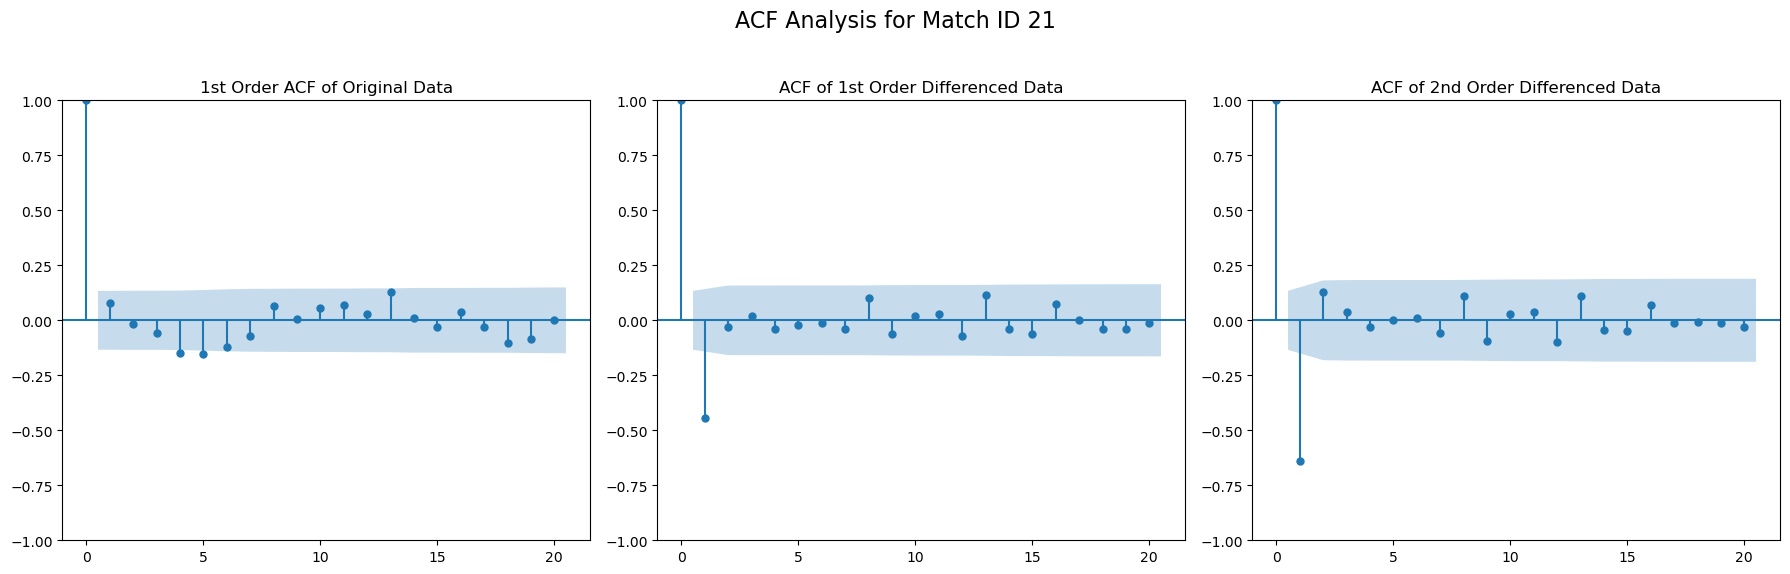

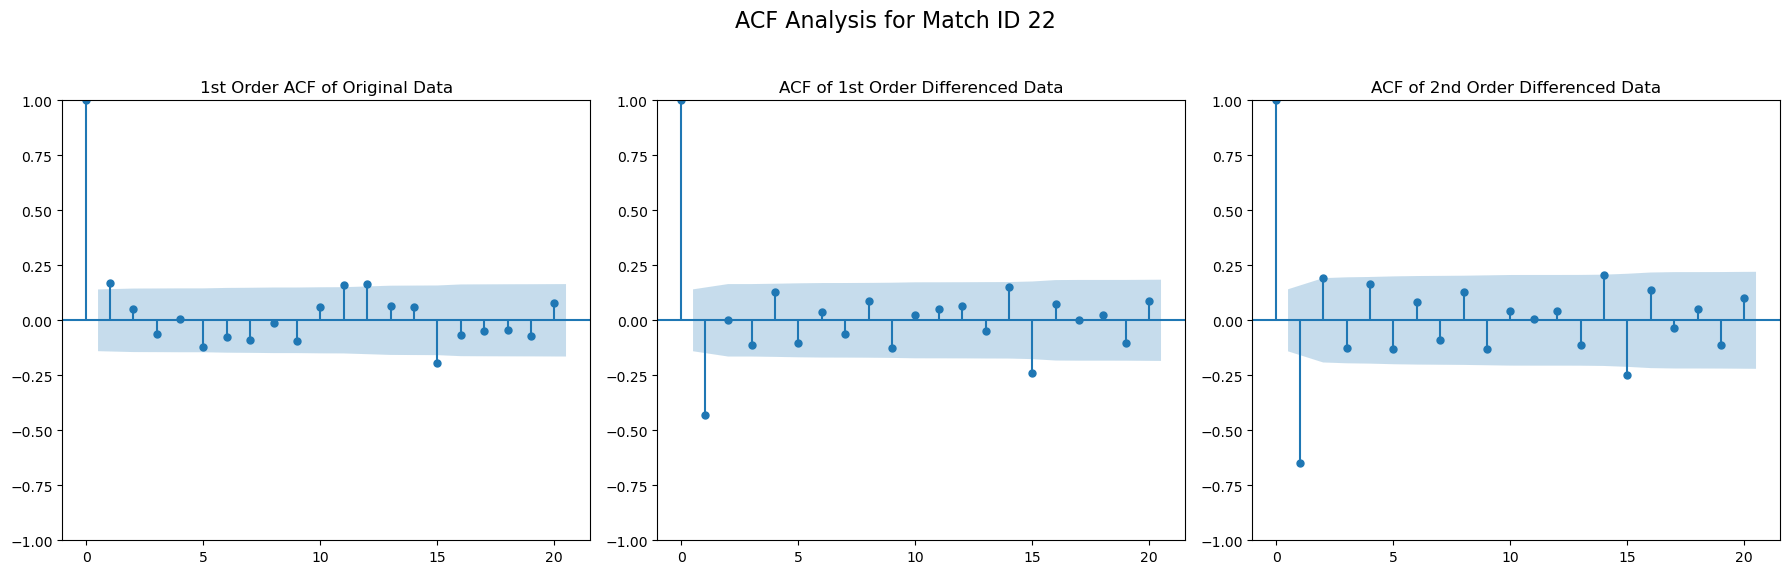

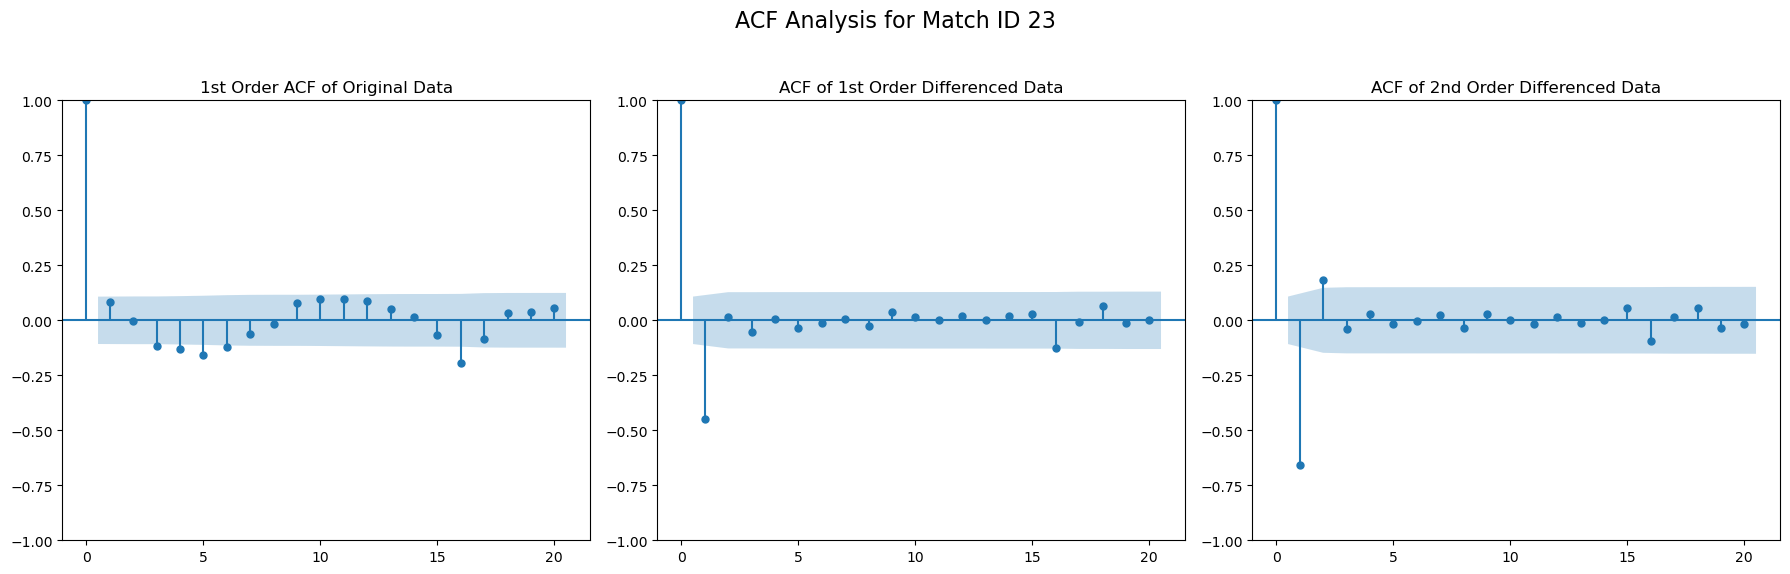

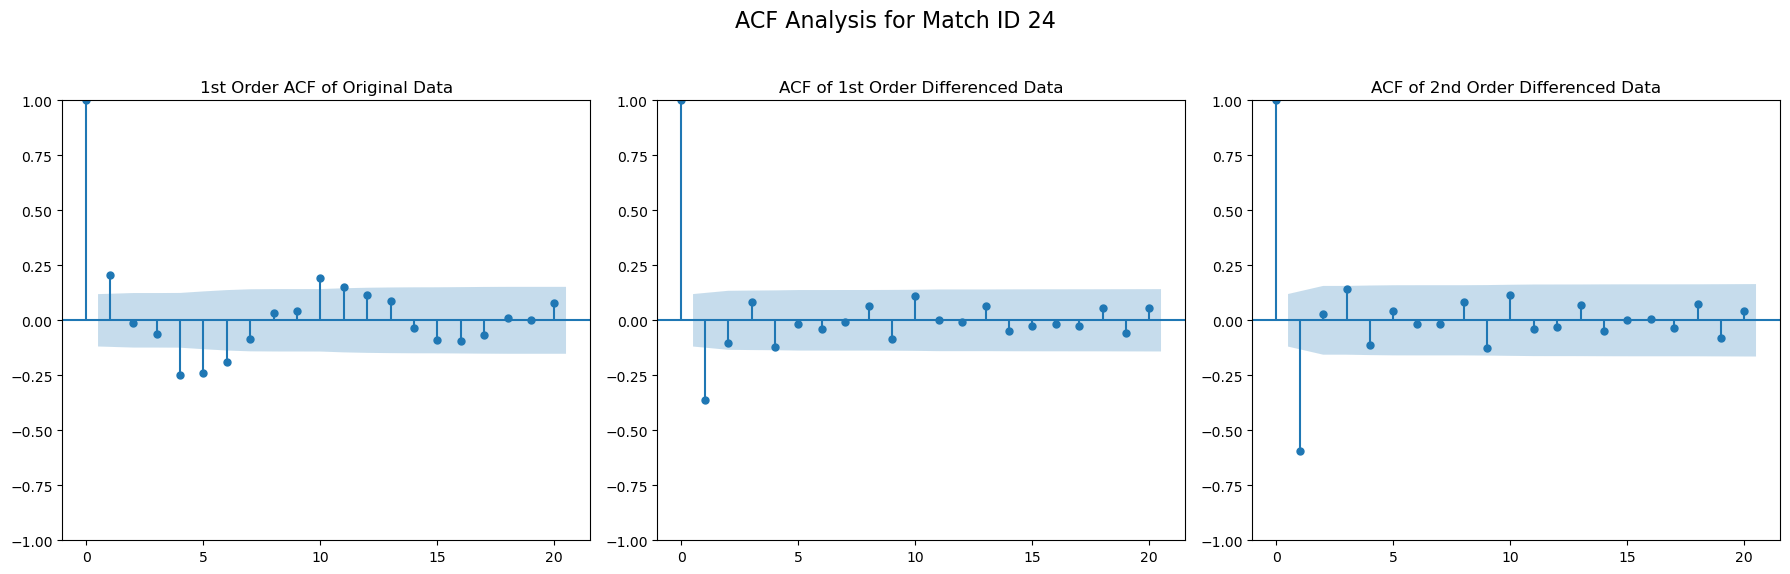

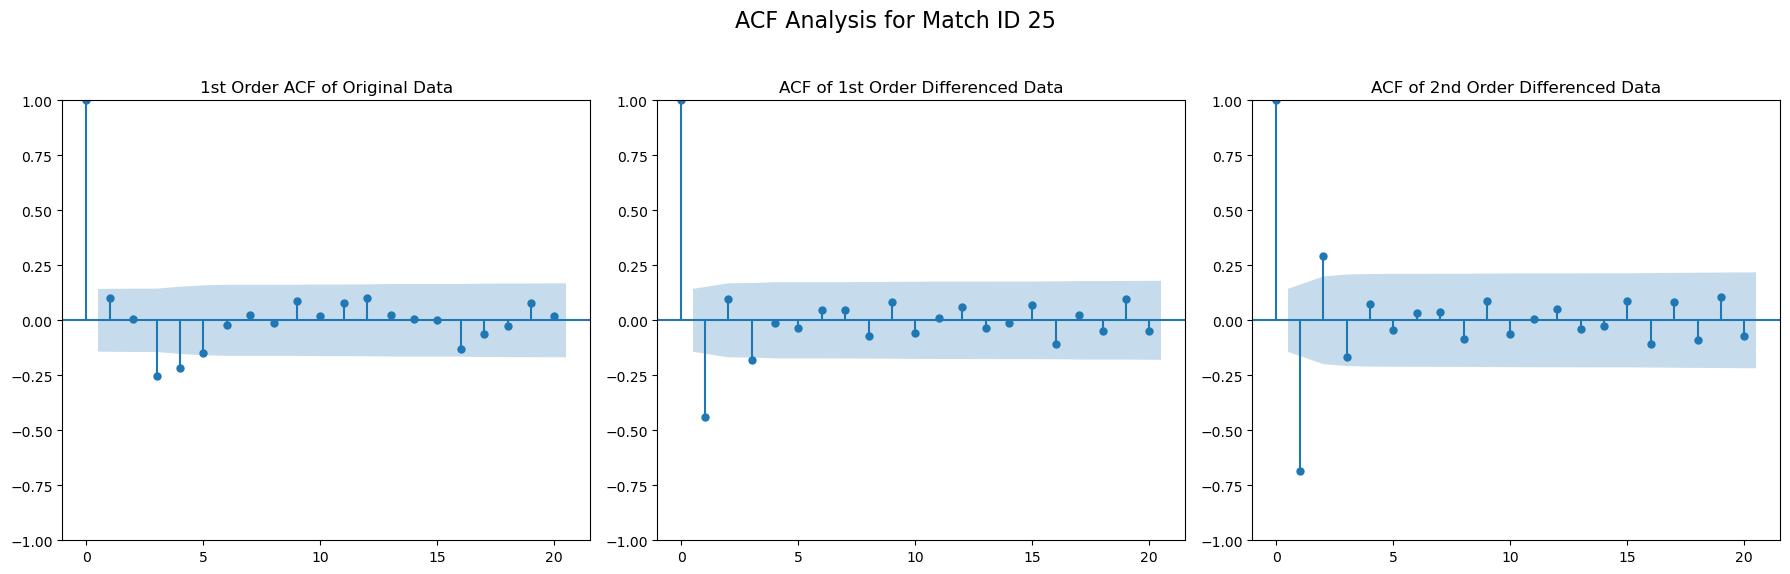

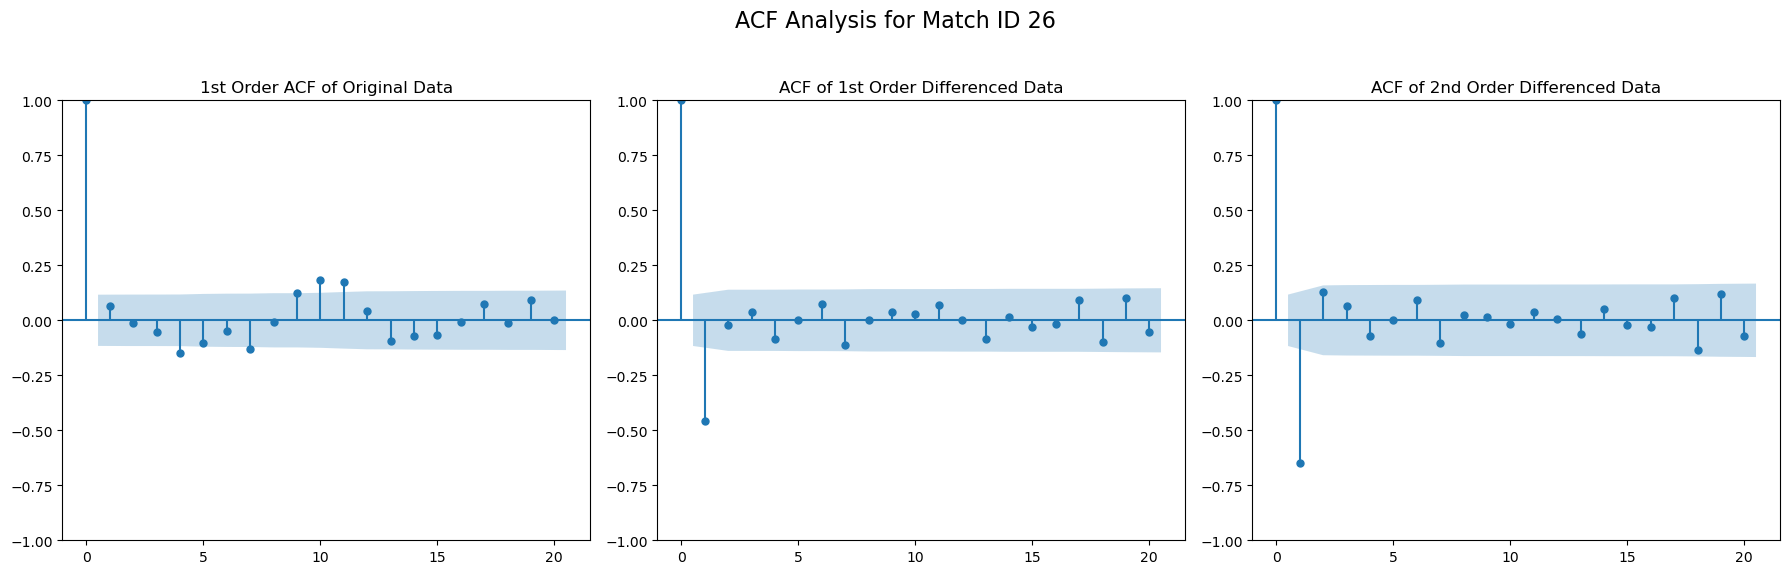

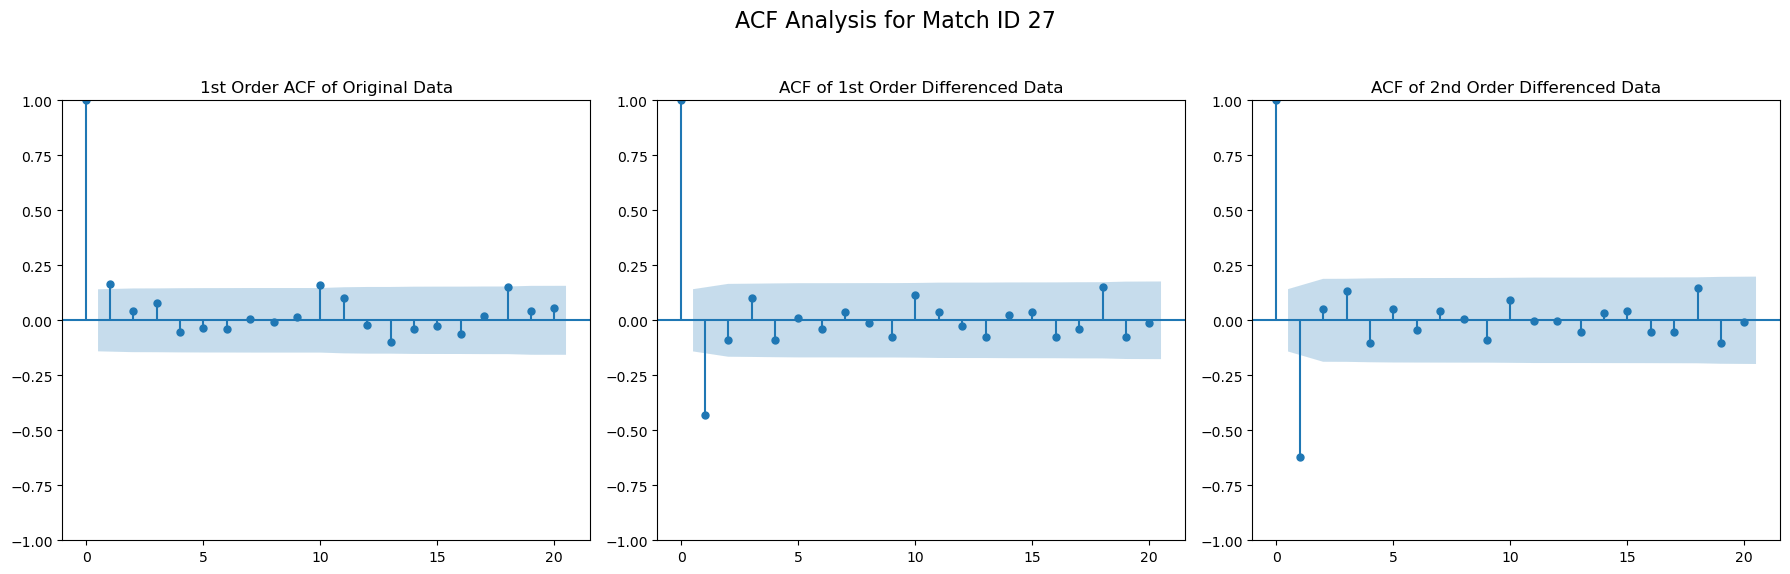

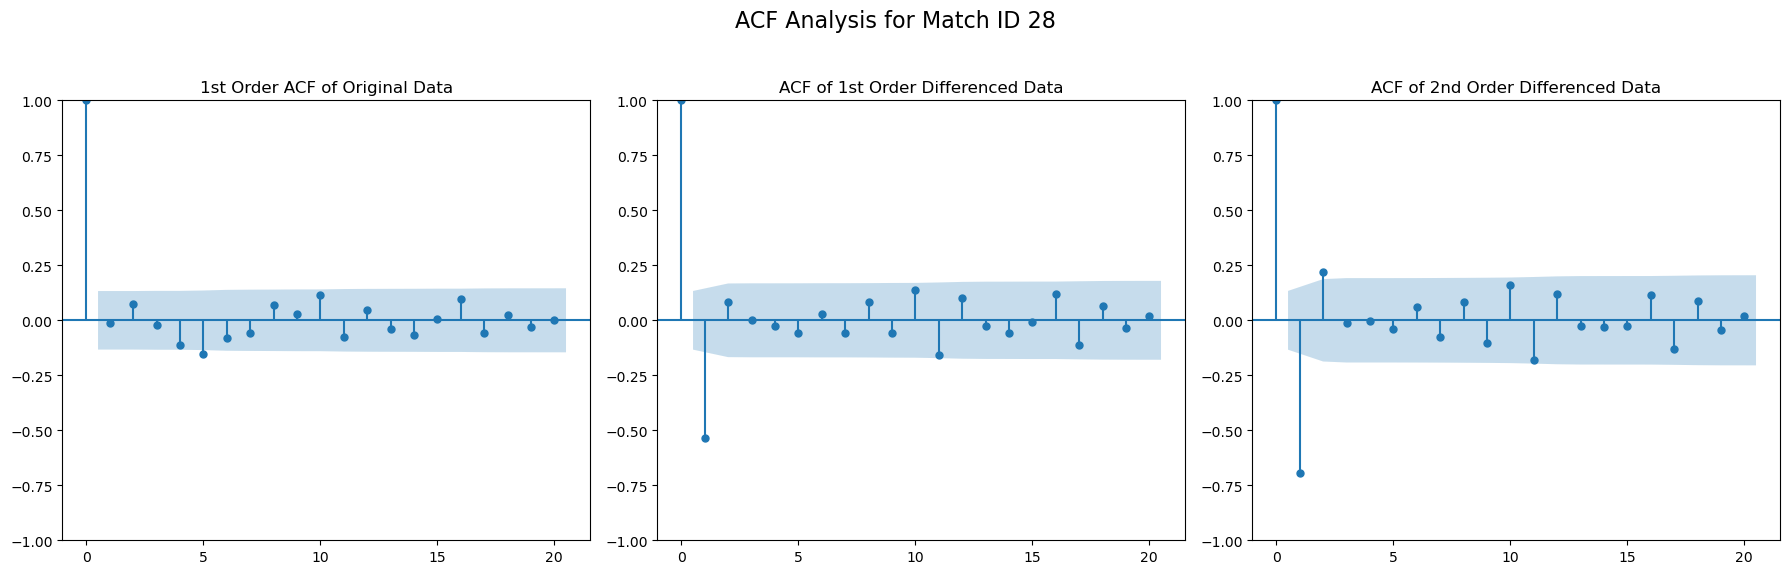

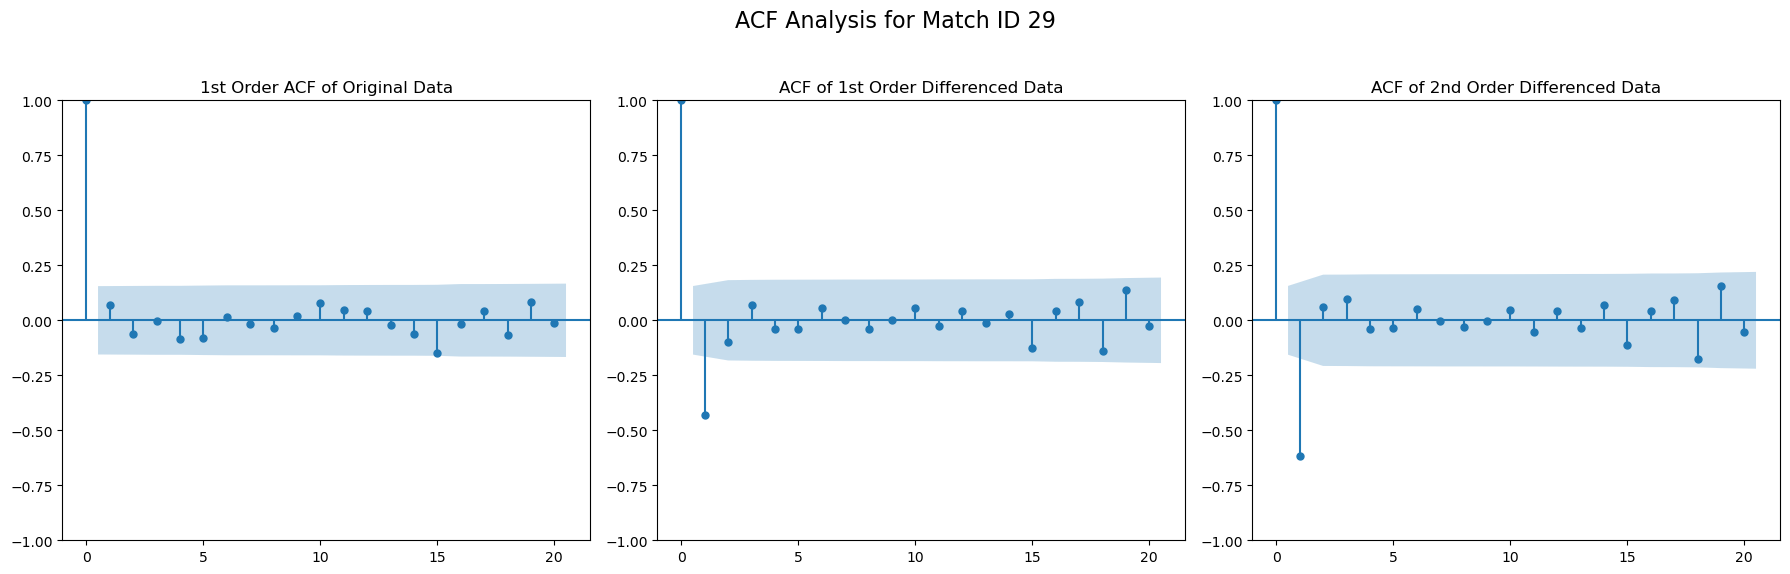

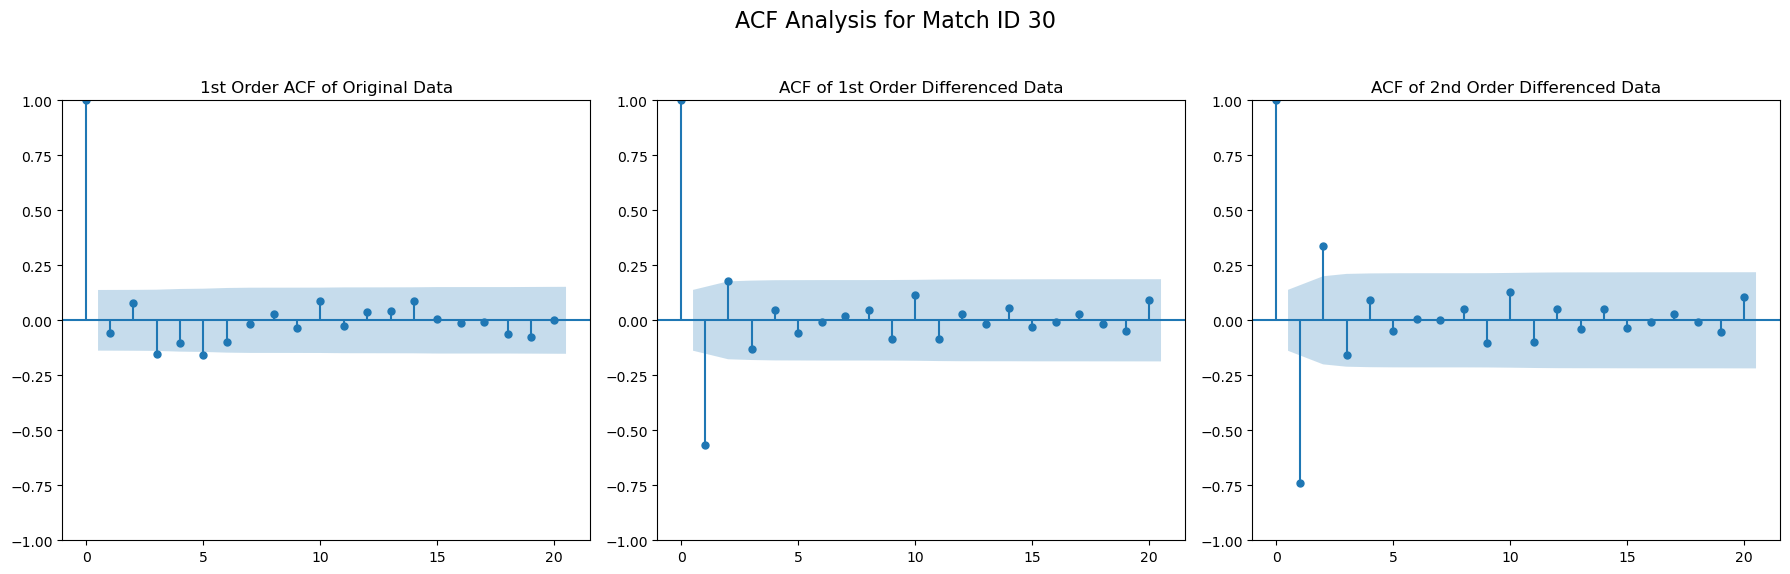

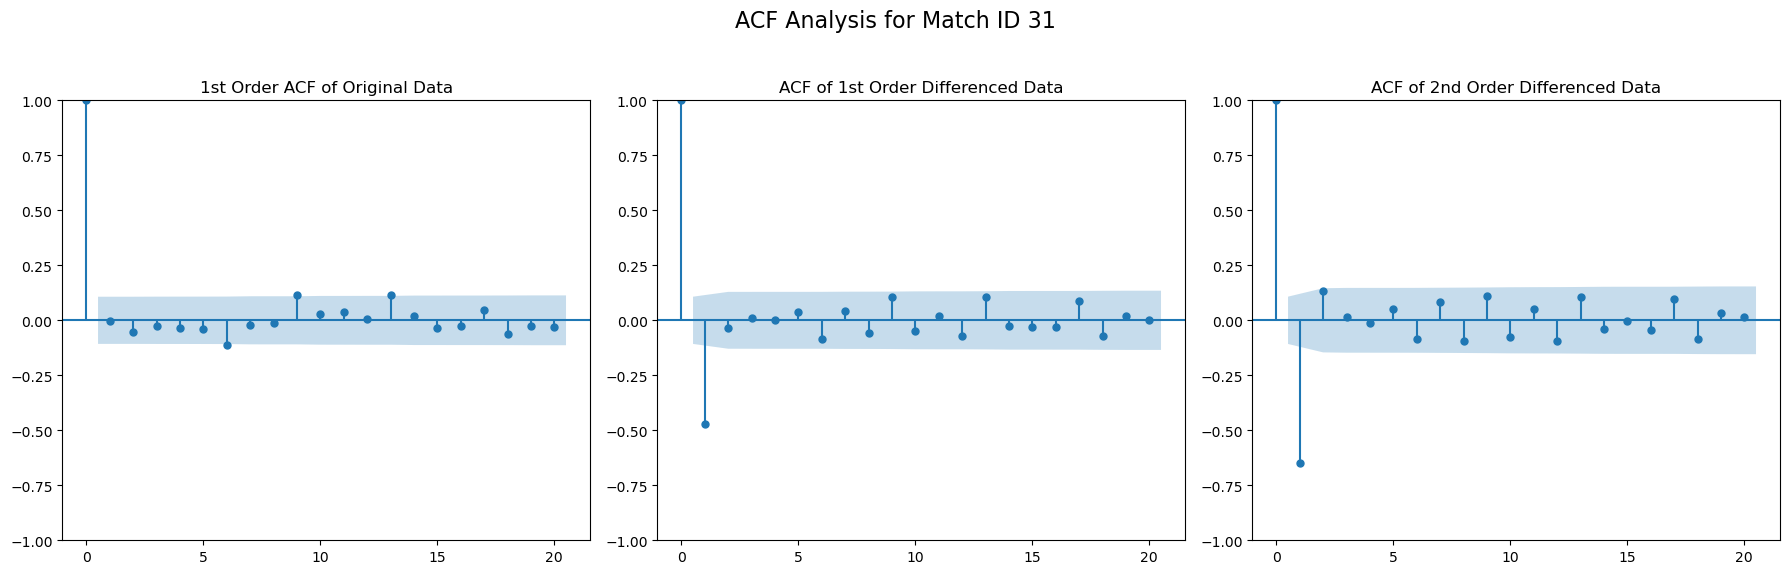

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

df['binary_victor'] = df['point_victor'].apply(lambda x: 1 if x == 1 else 0)

for match_id in df['match_id'].unique():
    match_data = df.loc[df['match_id'] == match_id, 'binary_victor'].dropna()
    
    if len(match_data) > 3:

        fig, axs = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(f'ACF Analysis for Match ID {match_id}', fontsize=16)

        plot_acf(match_data, lags=20, ax=axs[0], title='1st Order ACF of Original Data')
        
        first_diff = match_data.diff().dropna()
        plot_acf(first_diff, lags=20, ax=axs[1], title='ACF of 1st Order Differenced Data')
        
        second_diff = match_data.diff().diff().dropna()
        plot_acf(second_diff, lags=20, ax=axs[2], title='ACF of 2nd Order Differenced Data')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        save_path = f'image/acf-match-{match_id}.png'
        plt.savefig(save_path, dpi=300)
        plt.show()